In [6]:
import tushare as ts
import matplotlib.pyplot as plt
import pandas as pd
import MySQLdb
import time
import datetime
import warnings
warnings.filterwarnings("ignore")
from imp import reload
import chan
ts.set_token('3aceab1cc8a61e74fc0a1d481d64bf0b6d4e177a90f4c3936014c0ac')
pro = ts.pro_api()

In [6]:
df = pd.read_csv('E:\jupyter\qushi-20190525-20190702.csv',index_col='index')
df_down = df[df.direction=='downdown']

In [7]:
result_df=pd.DataFrame()
min_day_n=30
for n, k in df_down.iterrows():
    ts_code = k.ts_code
    trade_price = k.trade_price
    trade_time = datetime.datetime.strptime(k.trade_time,'%Y-%m-%d %H:%M')
    delta10 = datetime.timedelta(days=30)
    end_time = trade_time+delta10
    print(ts_code)
    day_df=None
    has_gotdata=False
    while not has_gotdata:
        try:
            day_df = pro.daily(ts_code=ts_code, start_date=trade_time.strftime('%Y%m%d'), end_date=end_time.strftime('%Y%m%d'))
            has_gotdata=True
        except OSError as e:
            print('pause 5s...',e)
            time.sleep(5)    
    day_df = day_df.iloc[::-1] #倒序
    day=0
    for day_n, day_k in day_df.iterrows():
        if day_k.vol>0:
            result_df=result_df.append({'ts_code':ts_code, 'trade_price':trade_price, 'trade_time':trade_time, 'date':day_k.trade_date ,'day': day, 'day_close_price':day_k.close, 'percent': (day_k.close-trade_price)*100/trade_price},ignore_index=True)
            day+=1
    min_day_n=min(min_day_n,day)

000650.SZ
000789.SZ
000919.SZ
000996.SZ
002013.SZ
002020.SZ
002117.SZ
002166.SZ
002219.SZ
002274.SZ
002348.SZ
002376.SZ
002394.SZ
002788.SZ
002864.SZ
002891.SZ
300029.SZ
300146.SZ
300176.SZ
300210.SZ
300238.SZ
300313.SZ
300508.SZ
600302.SH
600549.SH
600618.SH
600636.SH
600781.SH
600805.SH
600834.SH
600982.SH
603086.SH
603668.SH
603681.SH
603882.SH


In [5]:
result_df.groupby('ts_code')['percent'].mean().sort_values()

ts_code
000923.SZ    -9.190992
600797.SH    -8.736626
000616.SZ    -8.710854
002174.SZ    -8.609840
600496.SH    -8.607817
000818.SZ    -8.303094
000977.SZ    -8.070089
600569.SH    -7.829296
000673.SZ    -7.784431
600081.SH    -7.360468
300121.SZ    -7.061404
600478.SH    -6.920146
002507.SZ    -6.759531
601339.SH    -6.758802
300325.SZ    -6.607551
000059.SZ    -6.496604
601003.SH    -6.422018
300027.SZ    -6.382386
600825.SH    -6.378915
300021.SZ    -6.205534
600537.SH    -6.204519
002674.SZ    -6.129648
600242.SH    -5.826544
002542.SZ    -5.780678
600738.SH    -5.654153
300540.SZ    -5.435166
600782.SH    -5.418764
002590.SZ    -5.416513
600640.SH    -5.163714
603679.SH    -5.115604
               ...    
603888.SH    -2.213222
300396.SZ    -2.027097
603999.SH    -1.879002
002515.SZ    -1.722246
600105.SH    -1.663333
002363.SZ    -1.545128
300312.SZ    -1.465786
000539.SZ    -1.441881
300022.SZ    -1.093074
600750.SH    -1.052181
002438.SZ    -0.954911
300295.SZ    -0.641172
000

In [8]:
result_df[result_df.day<=7]['percent'].mean()

-0.5834096631447335

In [9]:
result_df['percent'].mean()

2.270976915772038

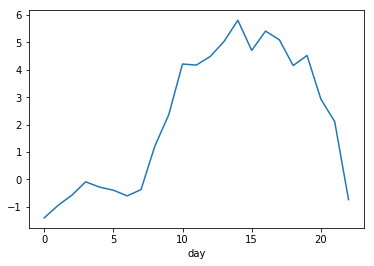

In [10]:
result_df.groupby('day')['percent'].mean().plot()

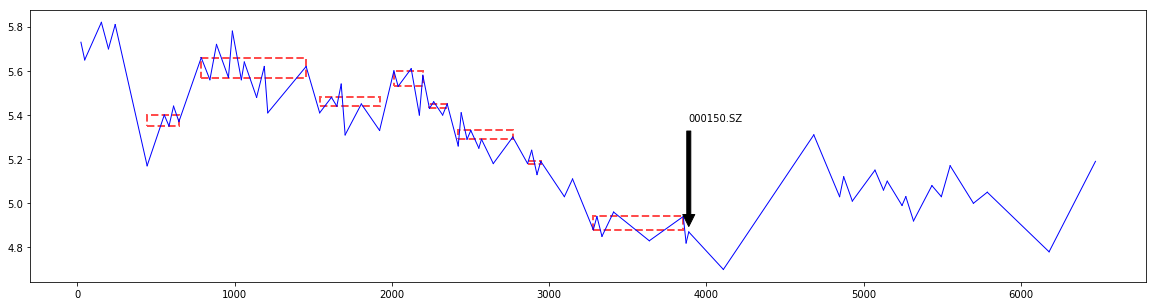

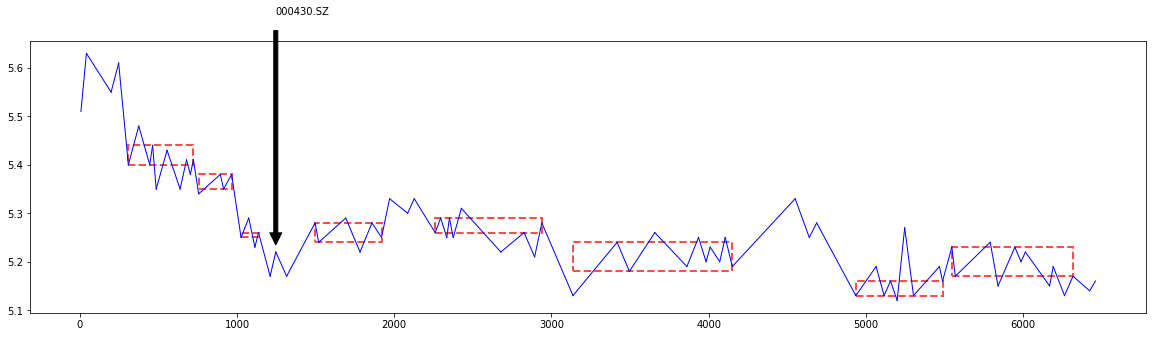

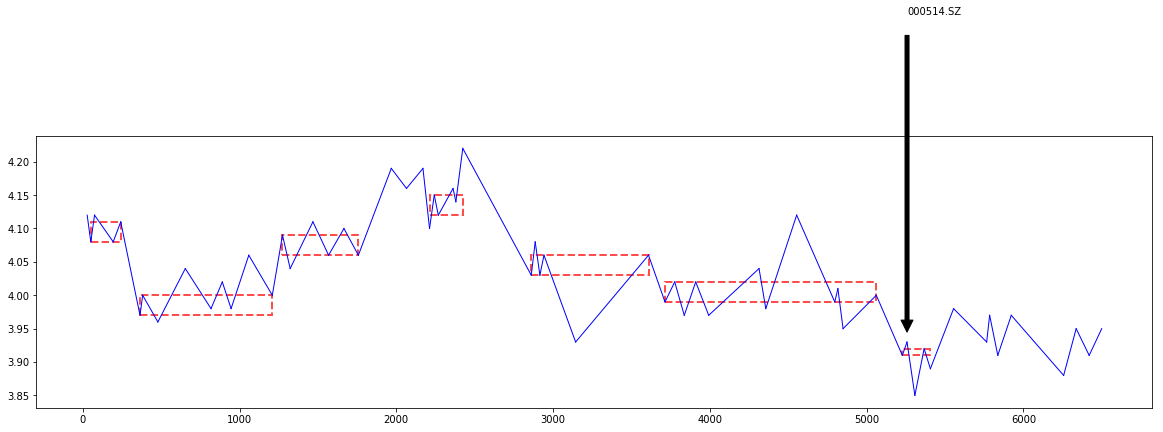

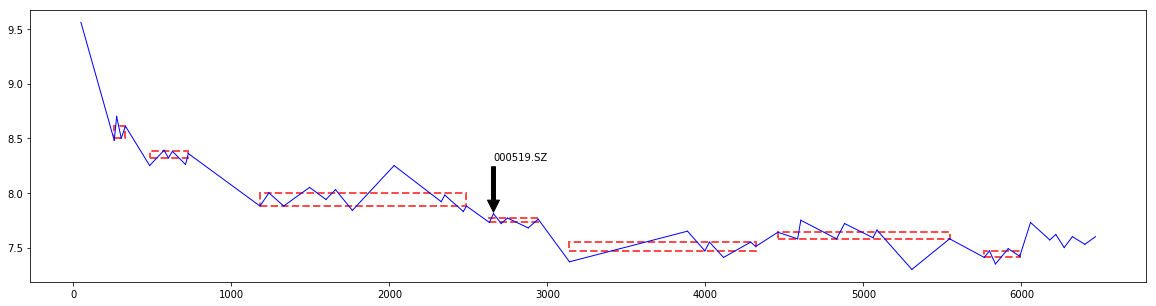

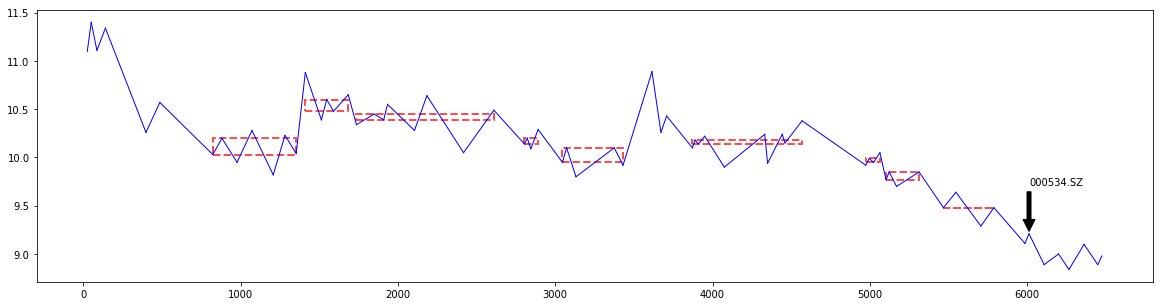

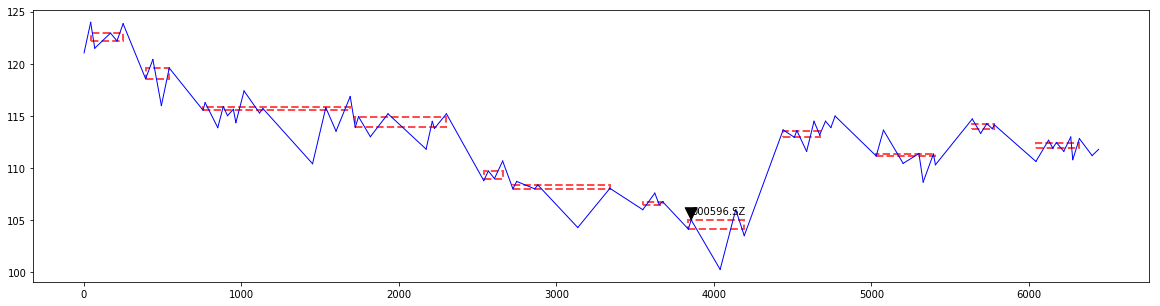

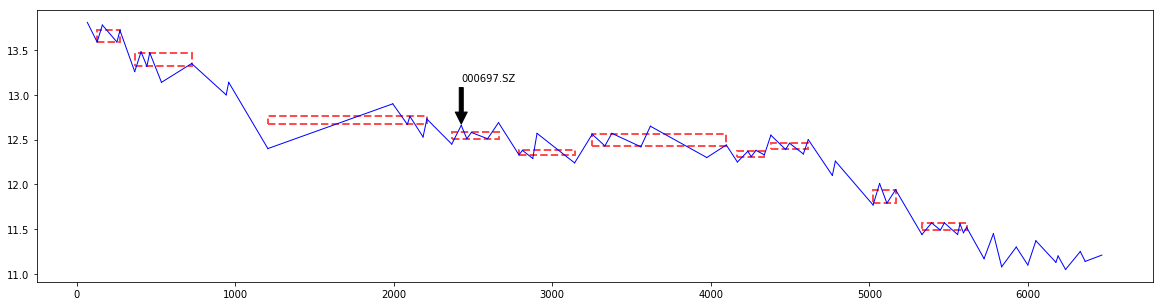

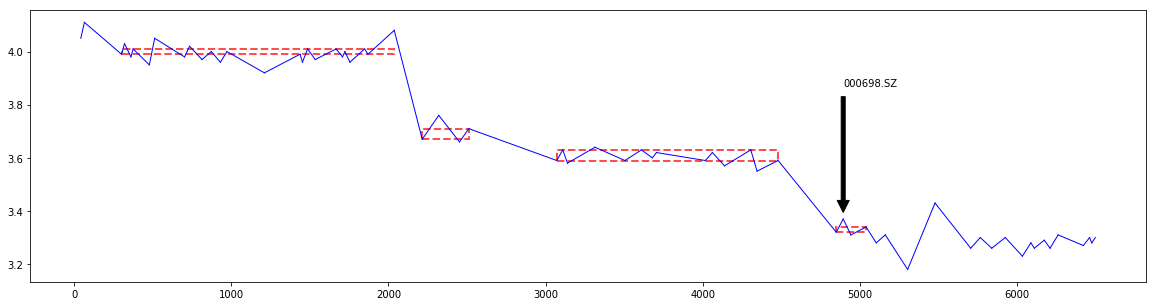

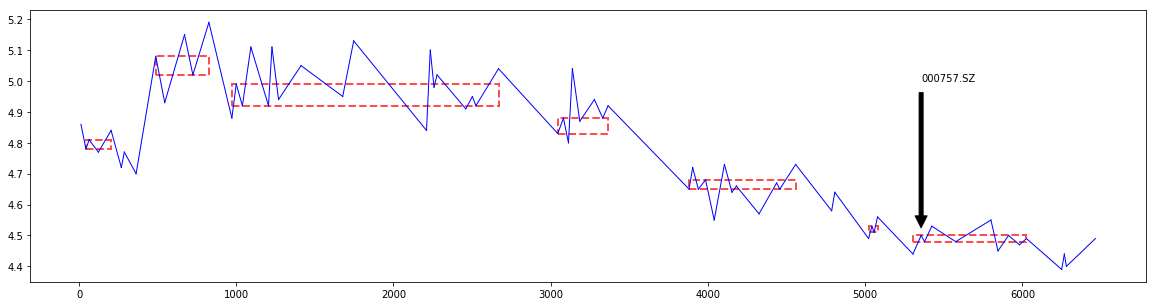

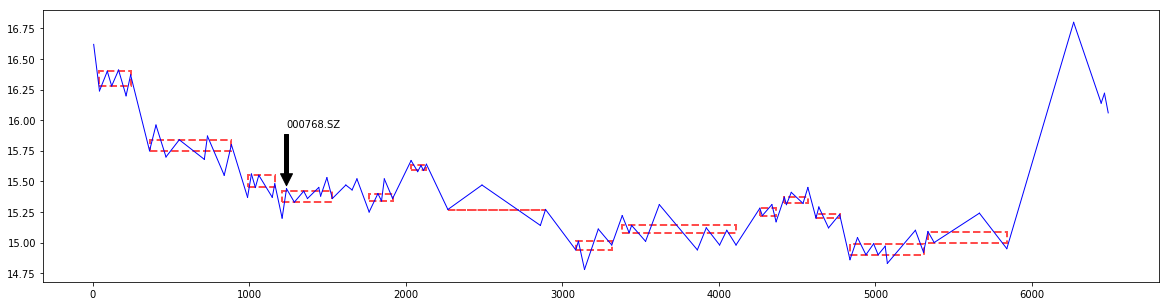

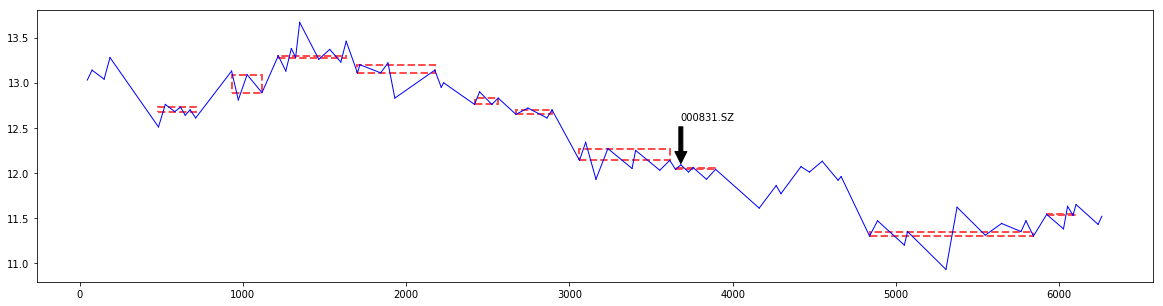

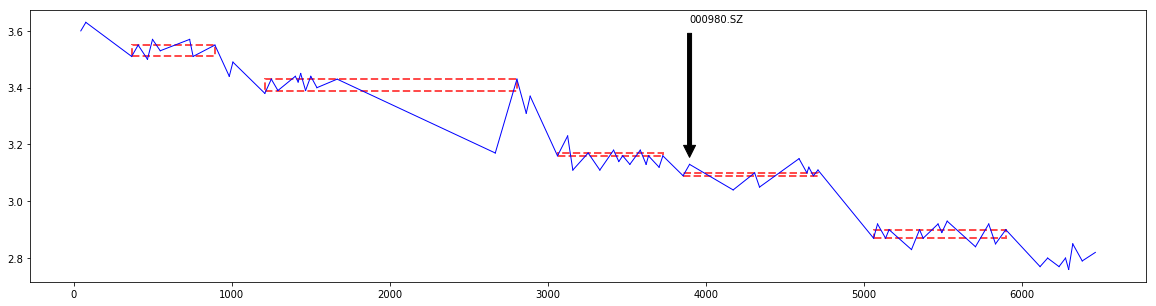

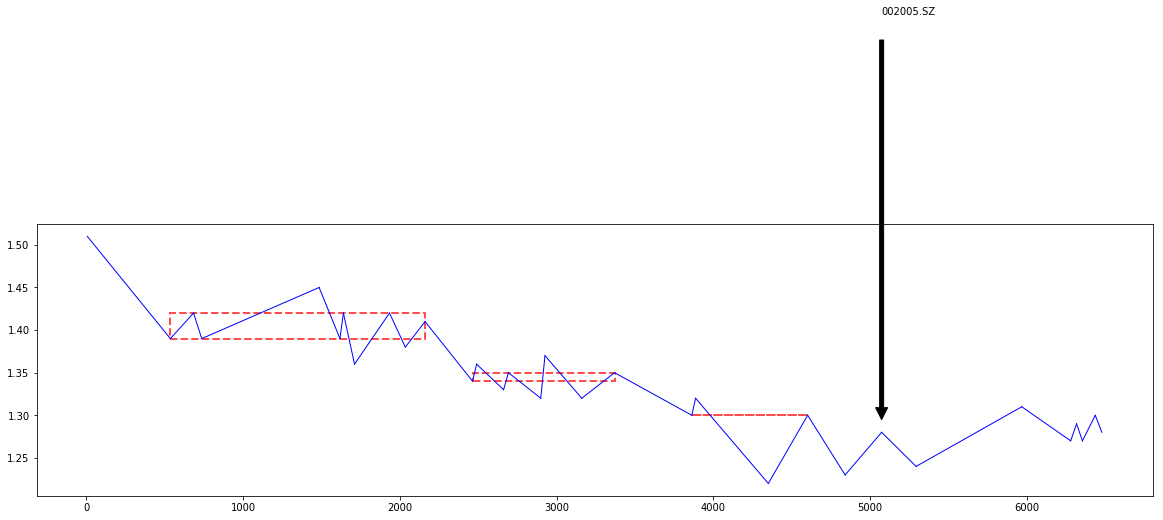

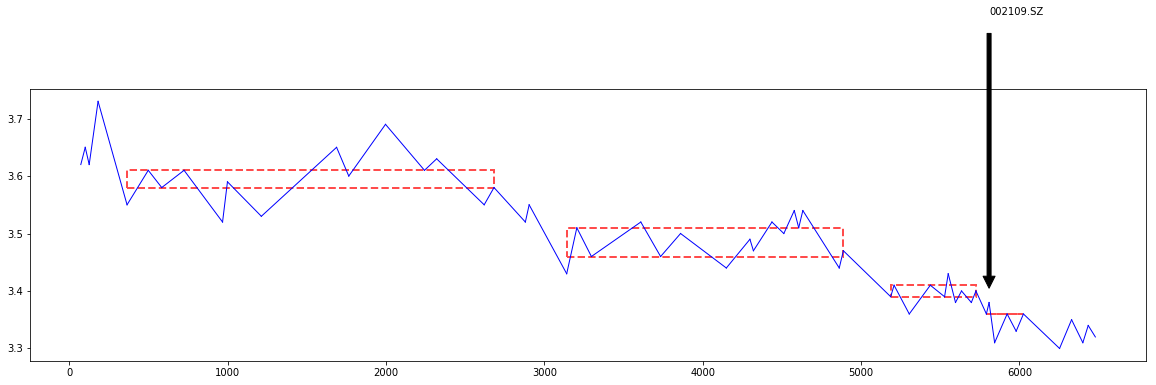

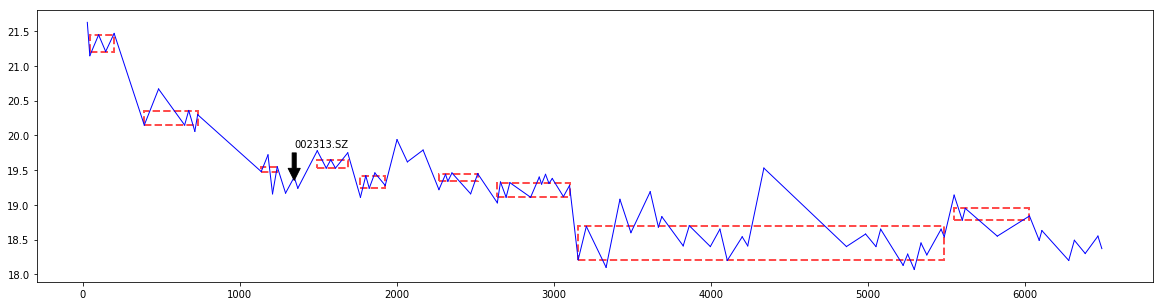

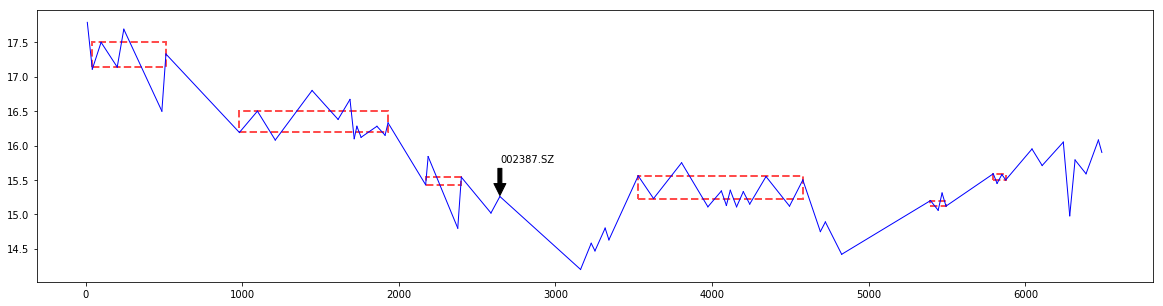

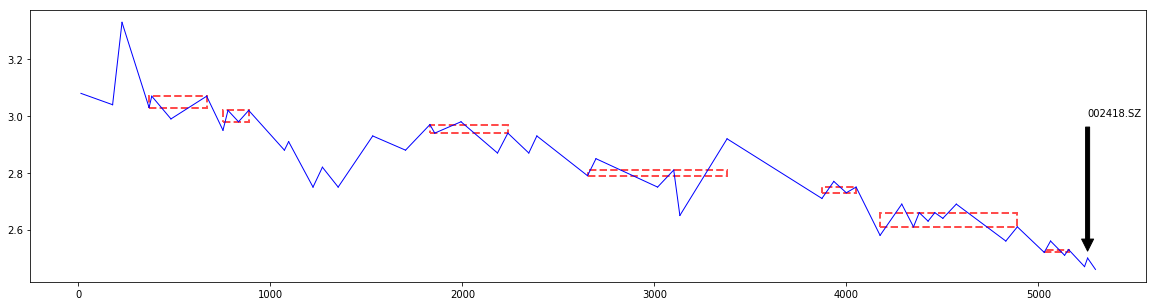

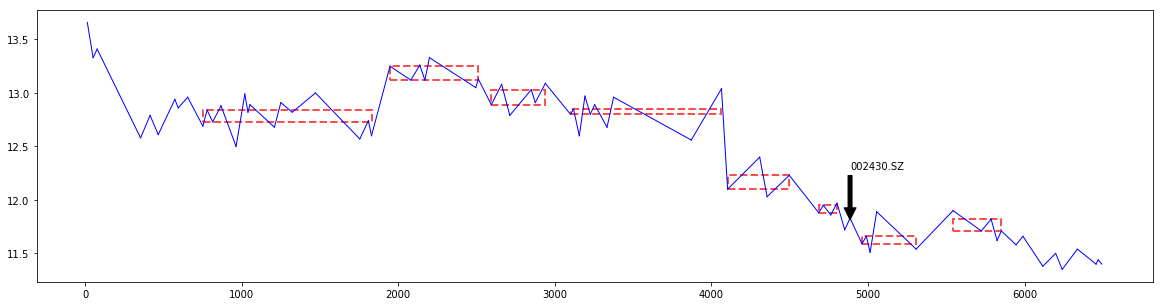

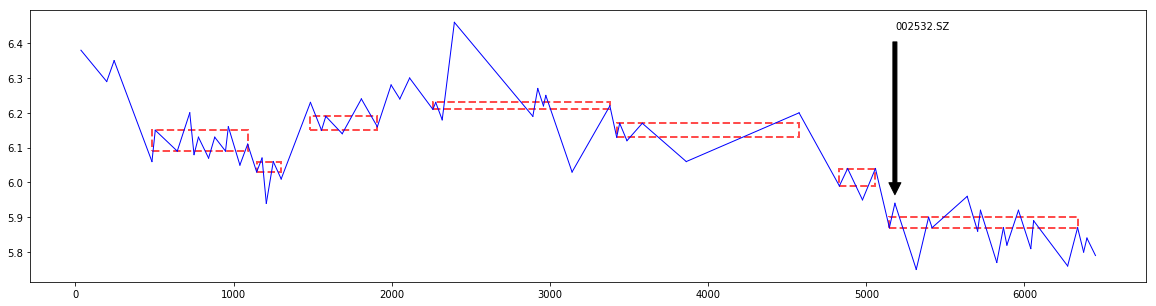

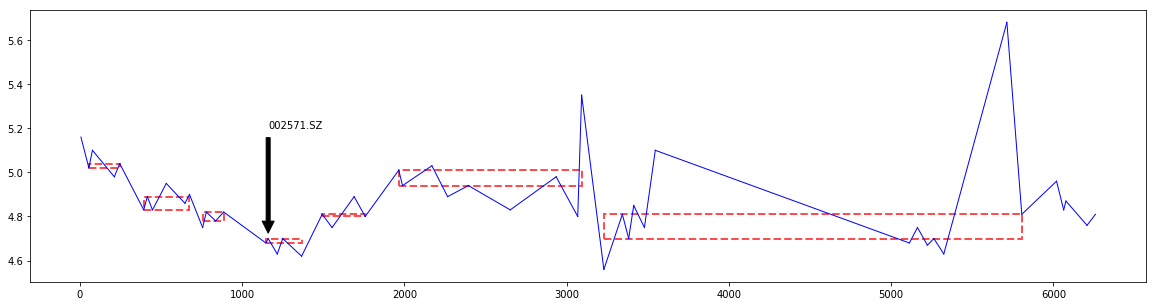

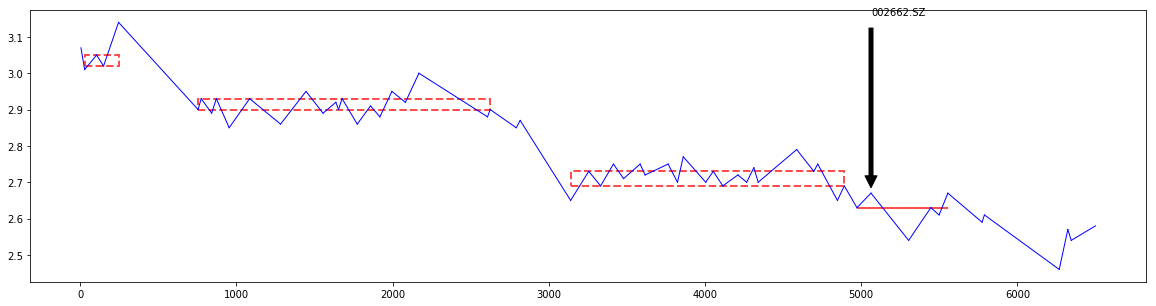

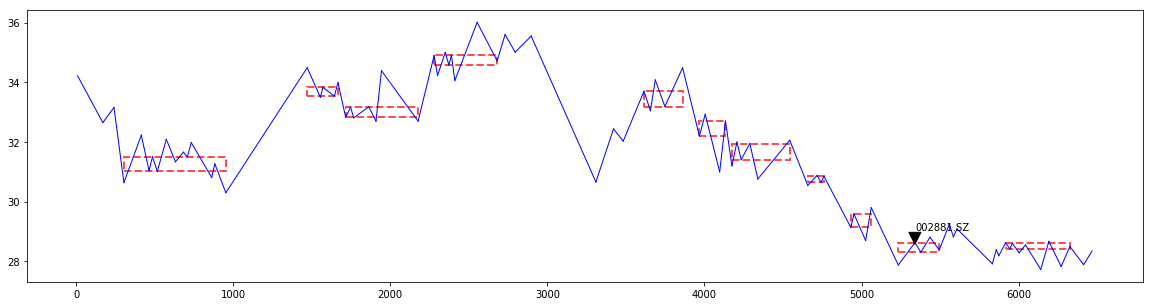

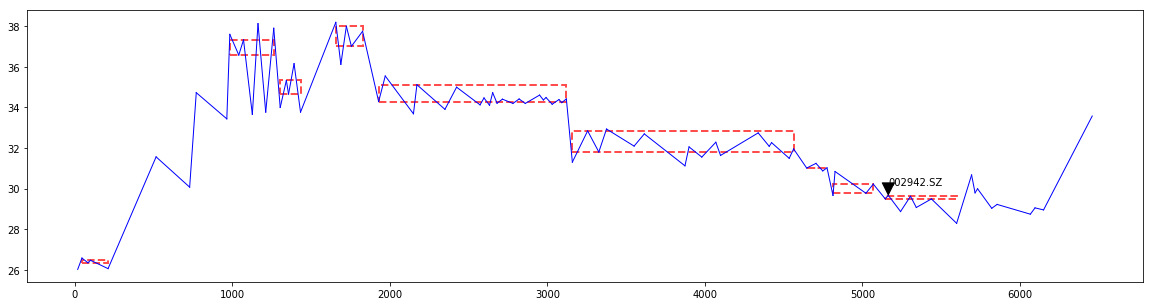

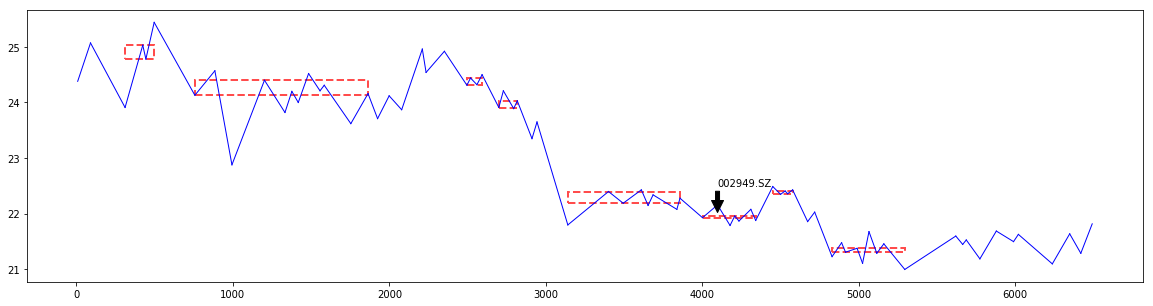

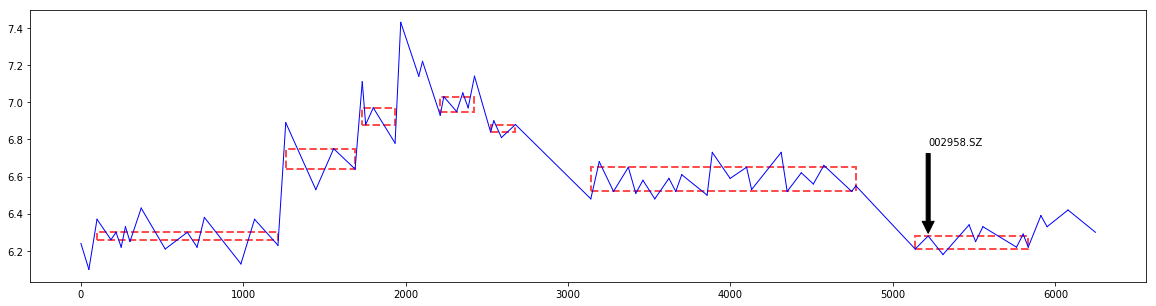

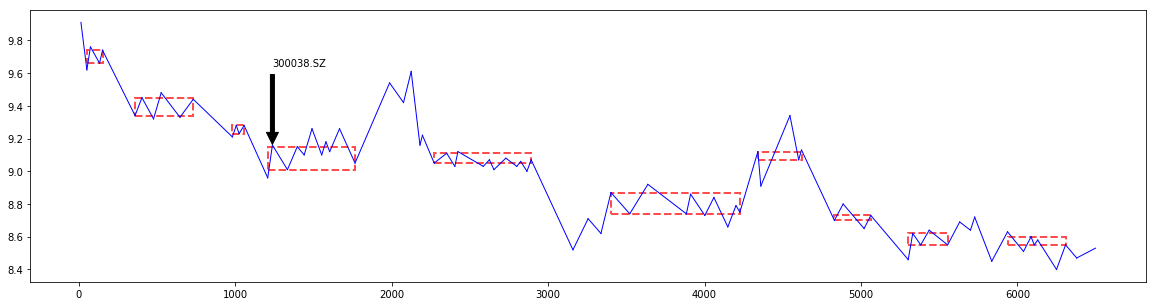

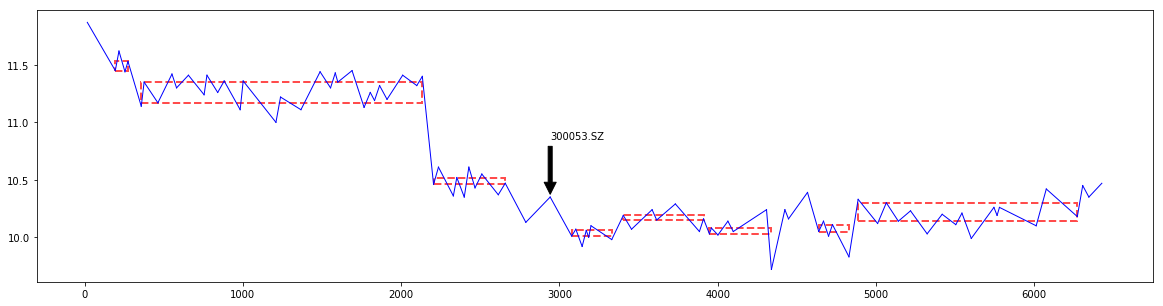

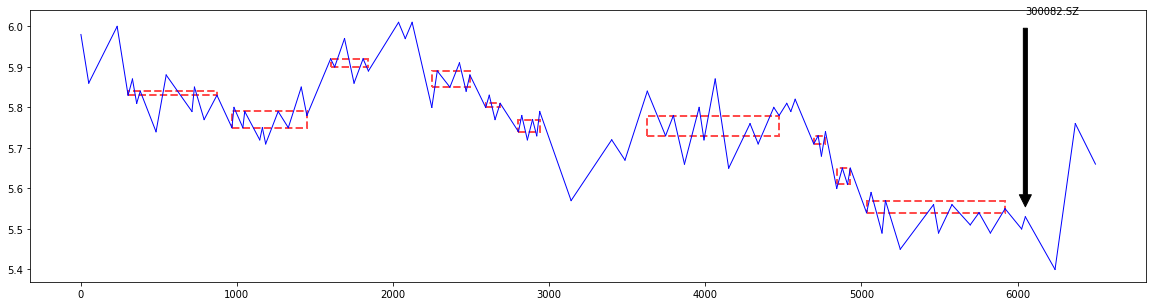

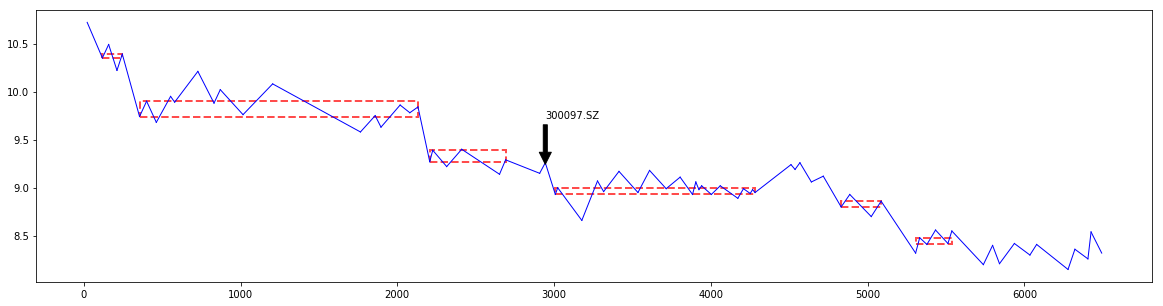

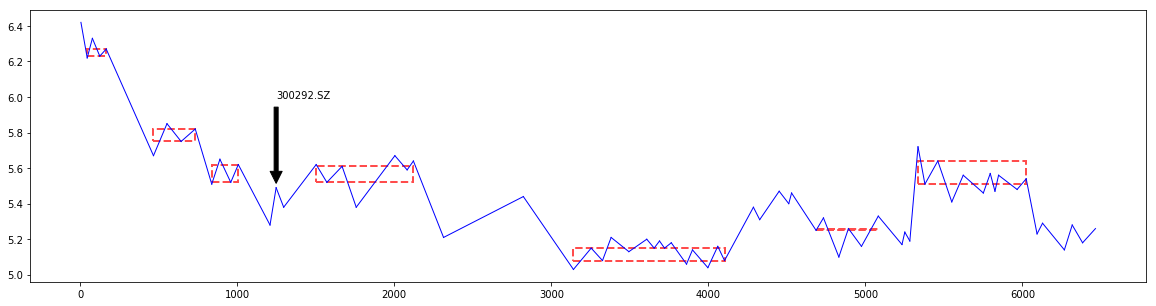

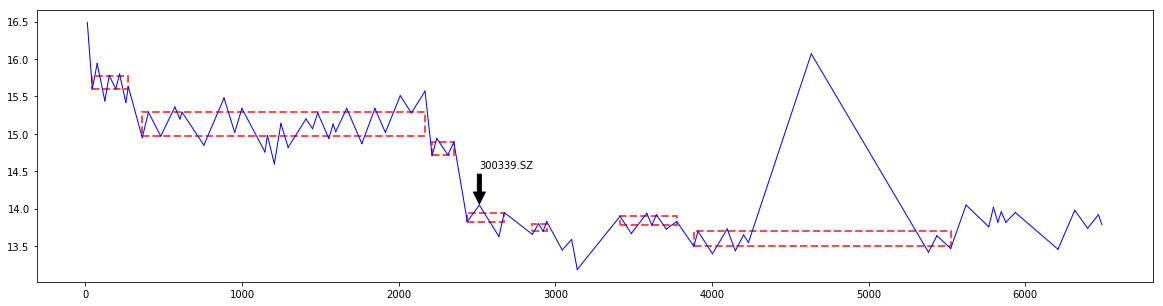

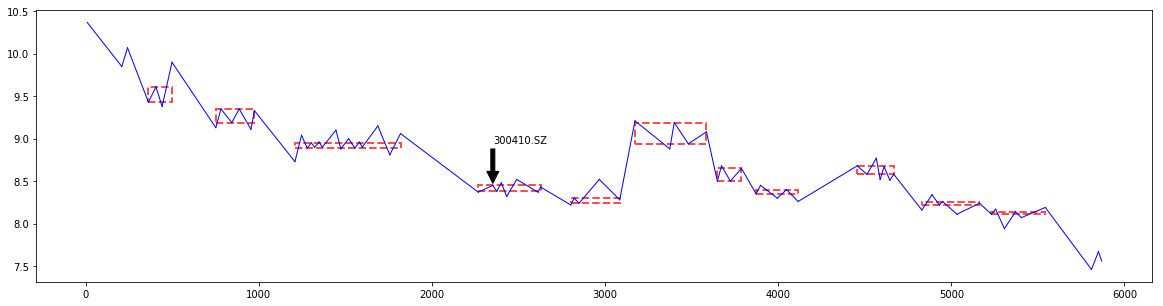

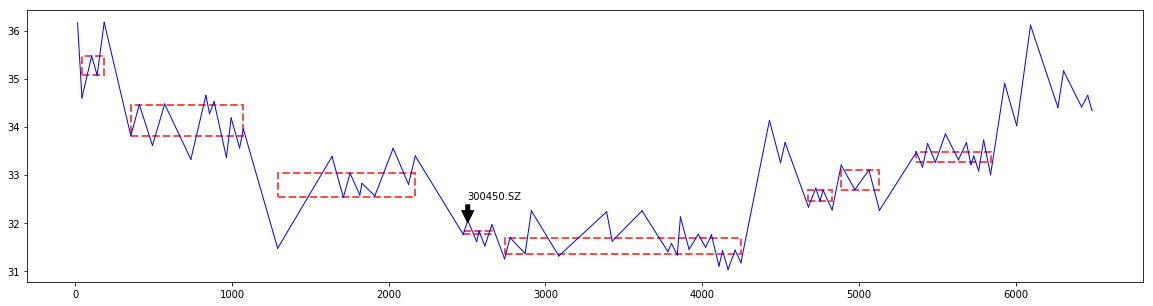

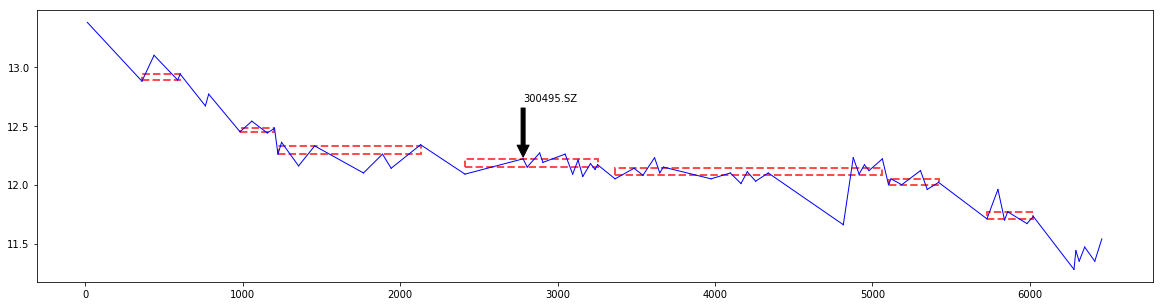

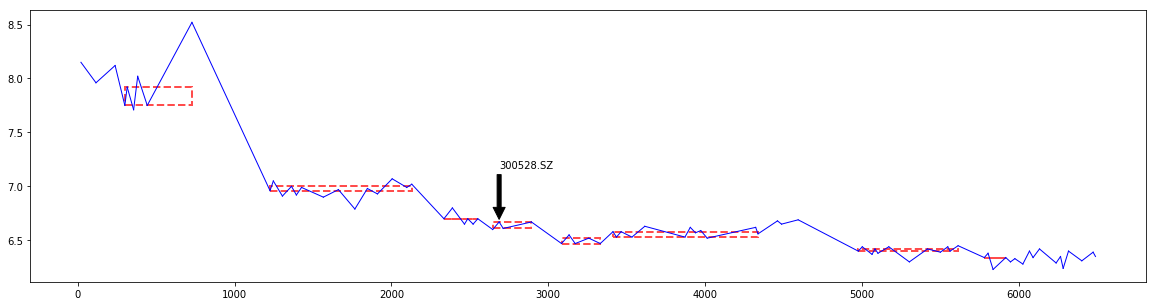

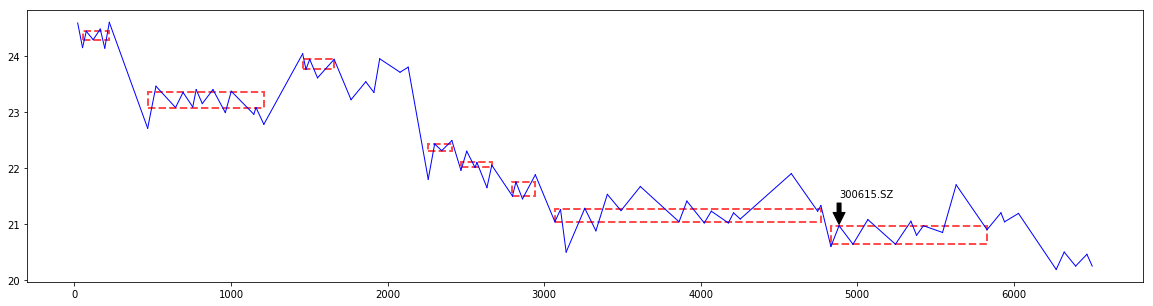

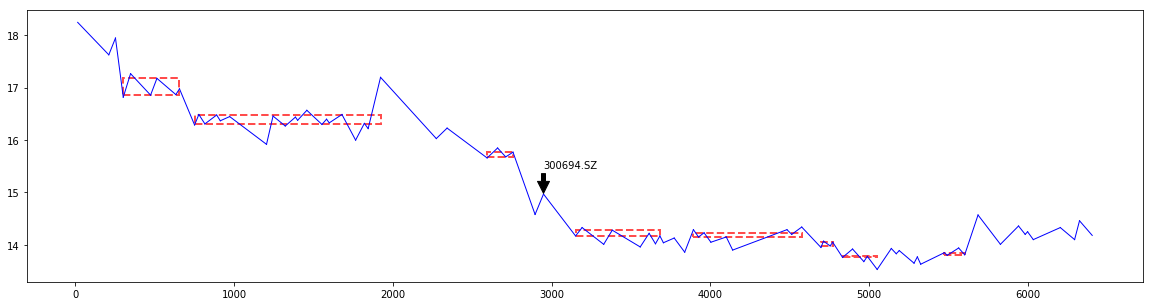

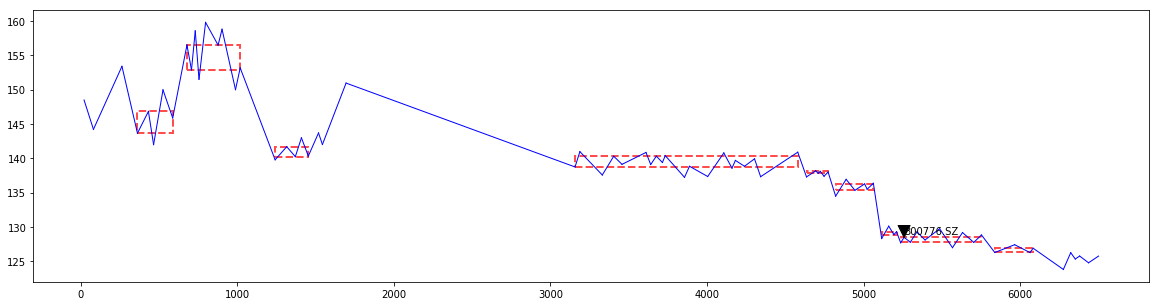

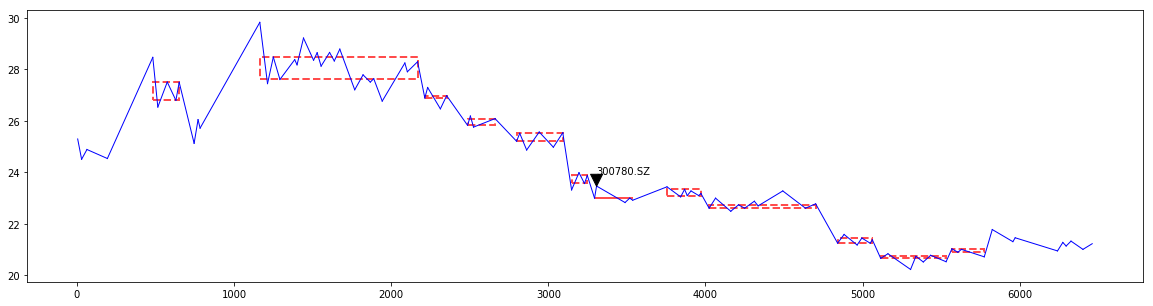

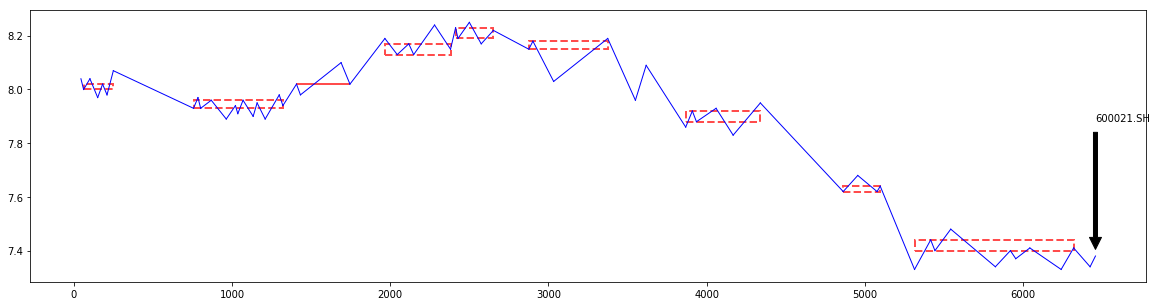

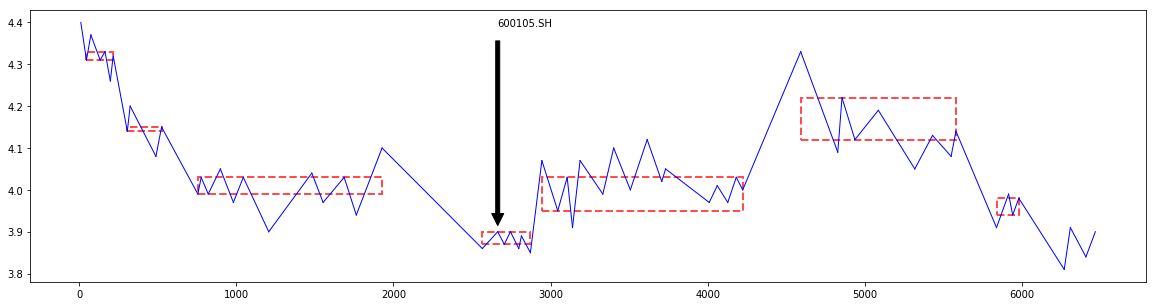

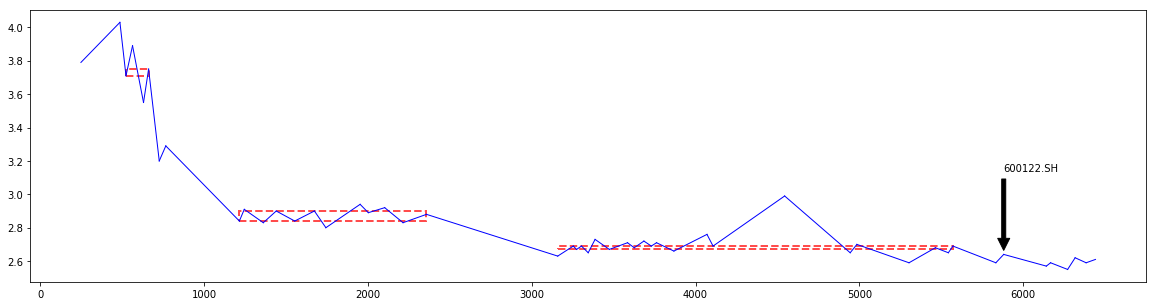

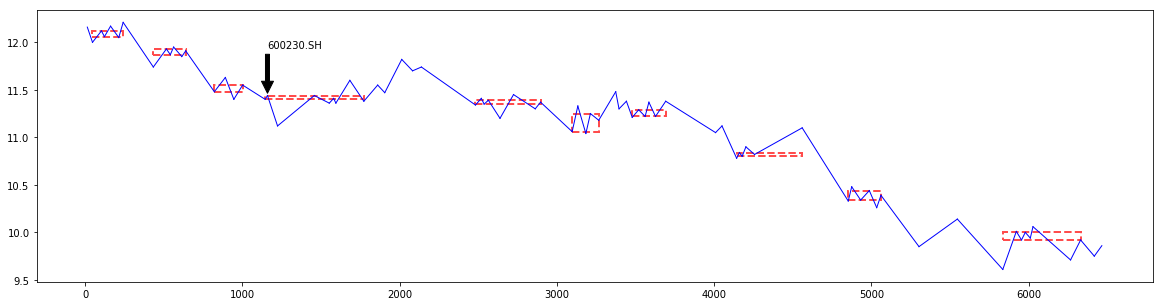

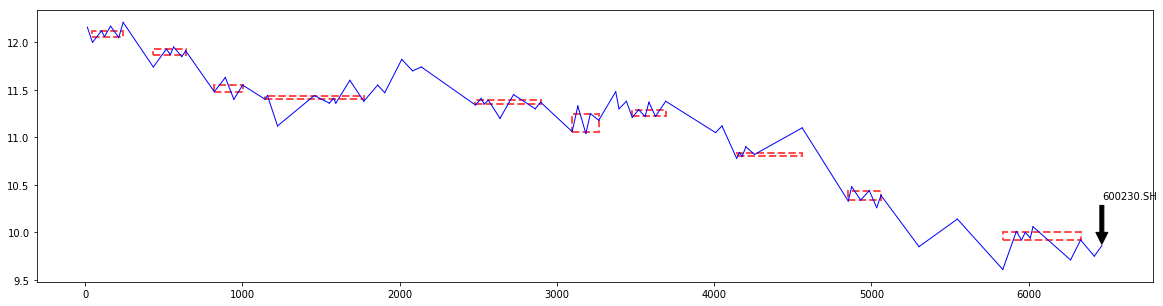

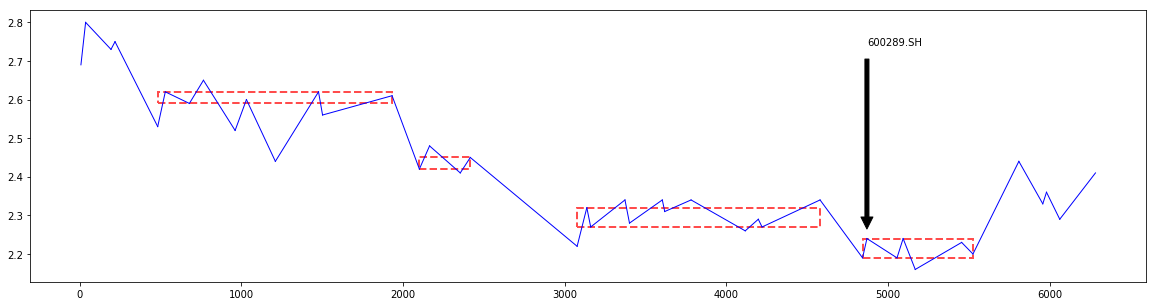

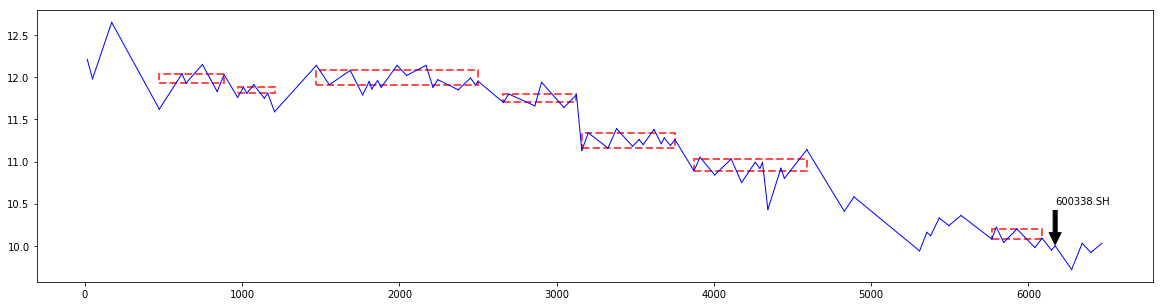

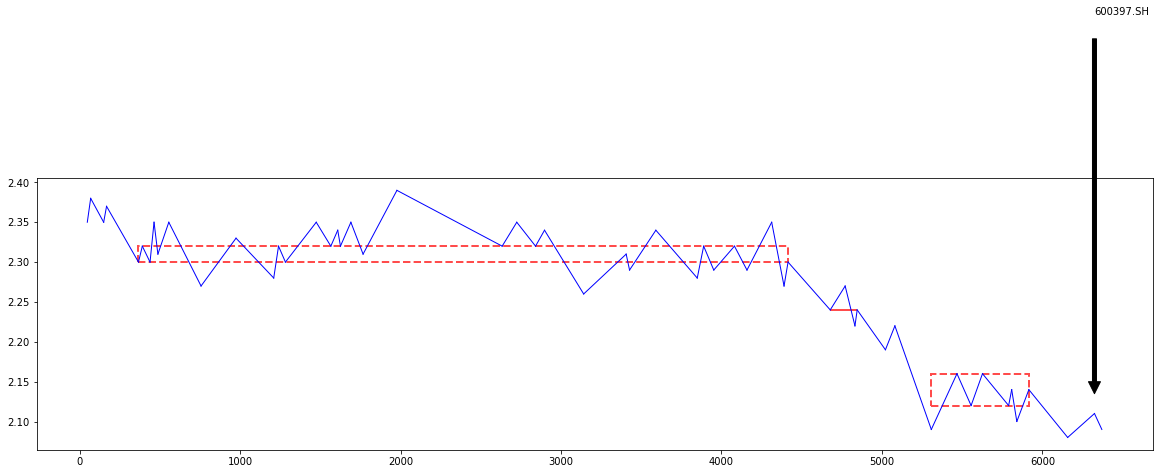

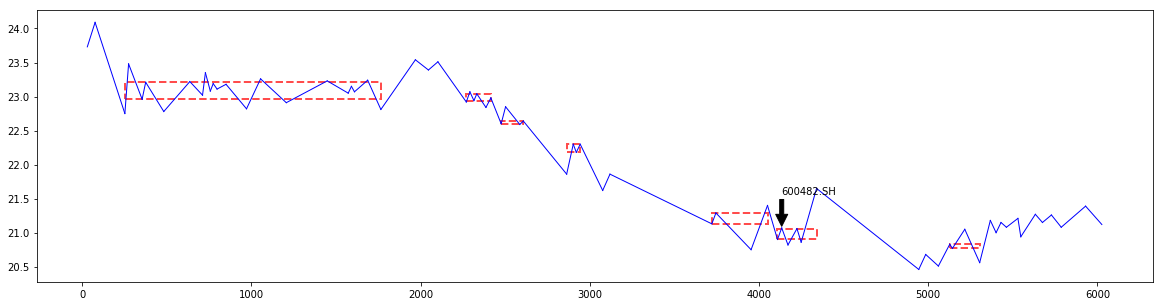

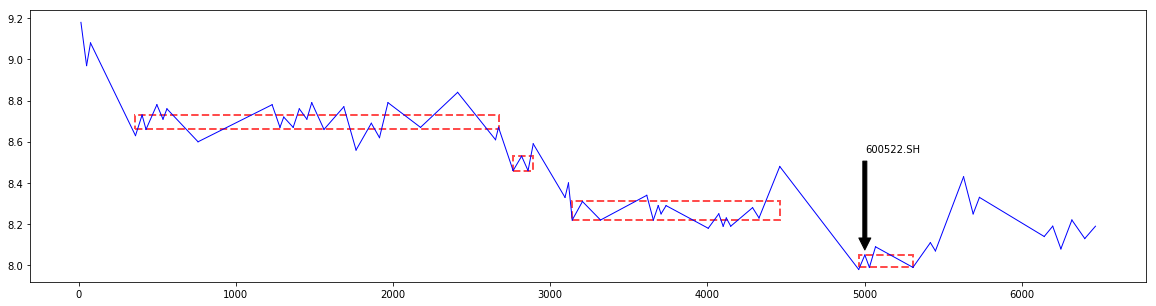

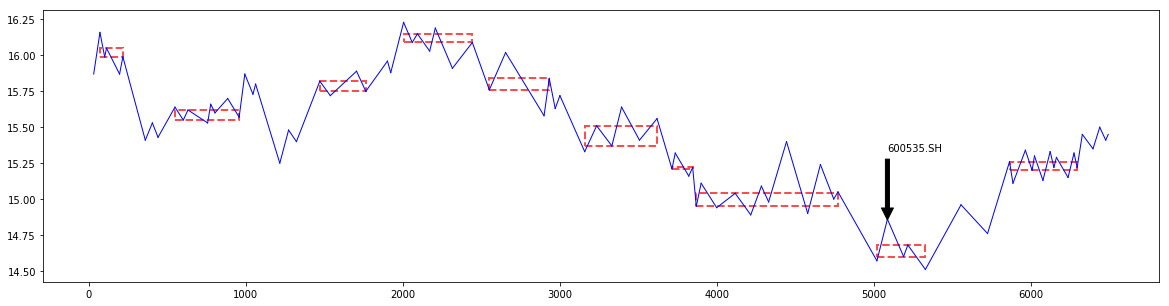

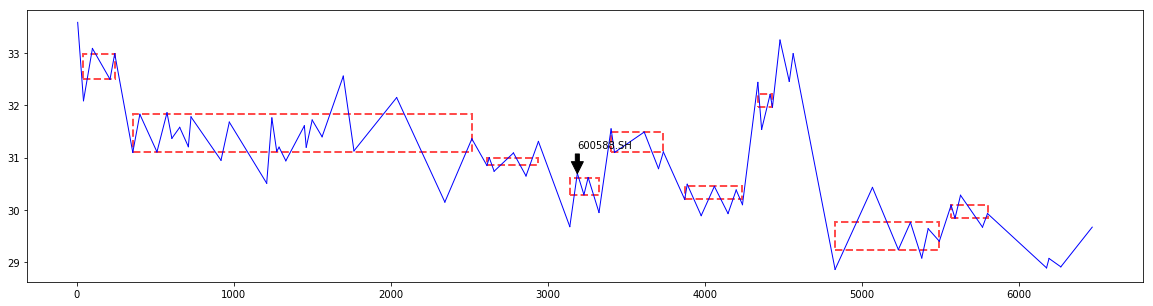

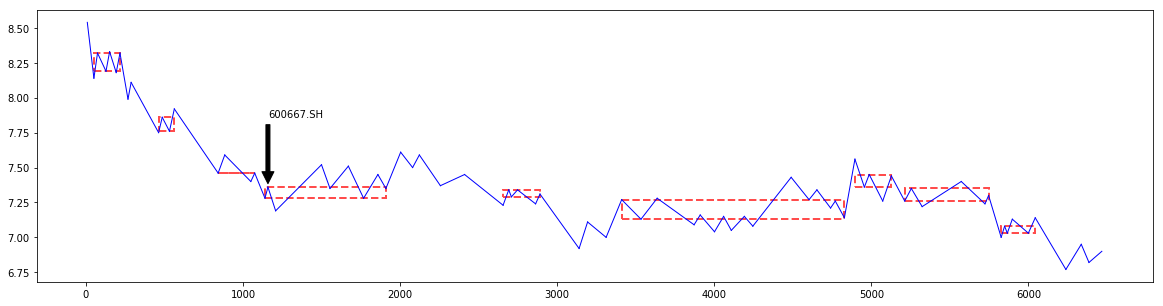

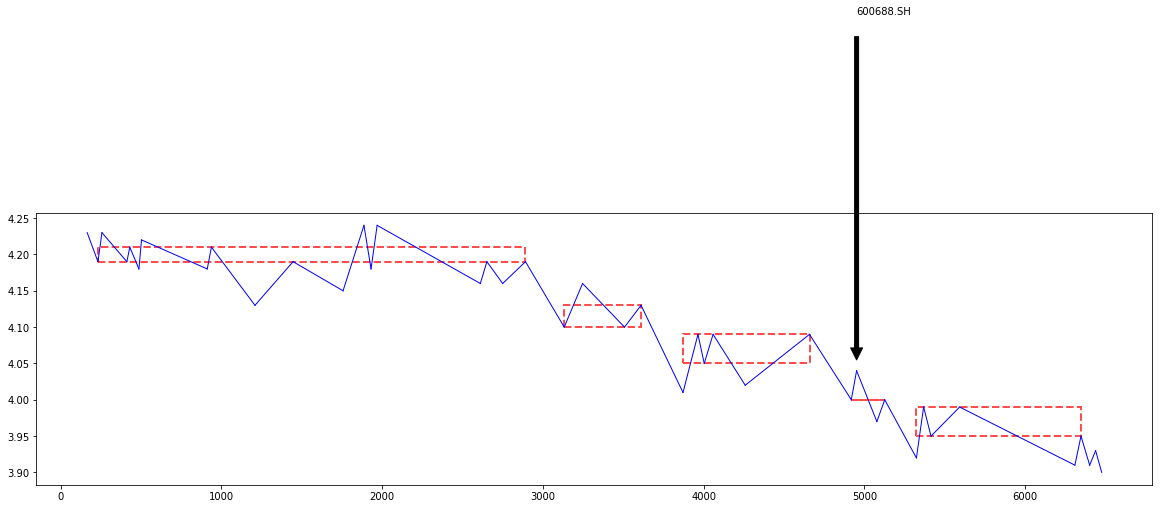

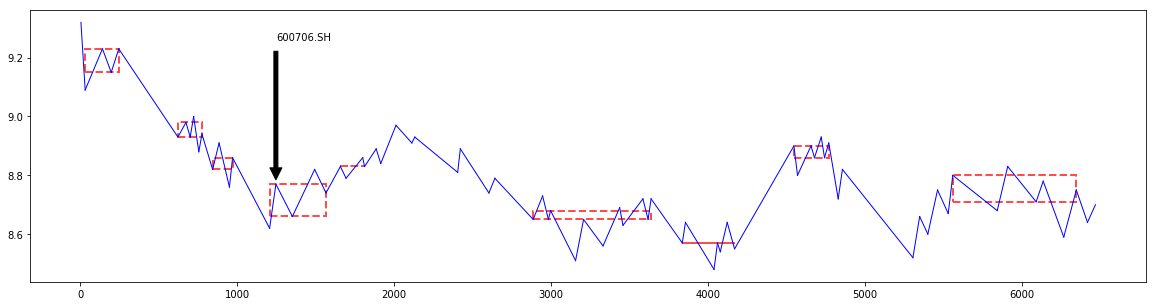

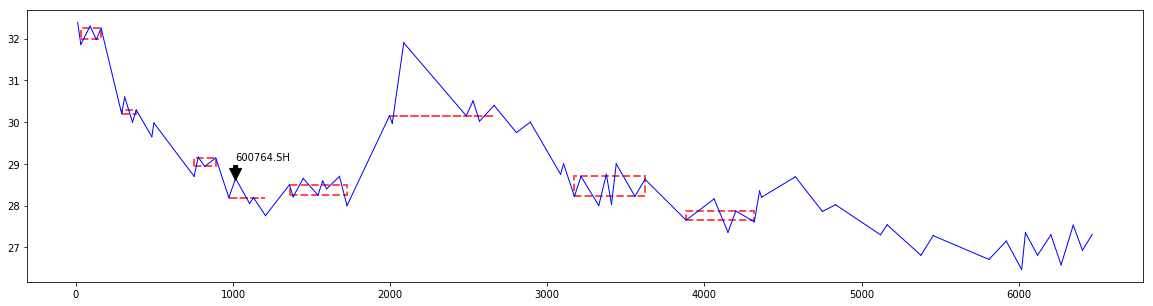

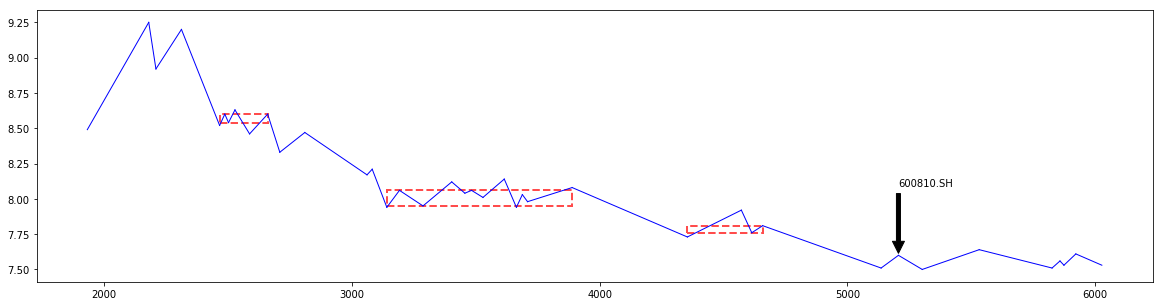

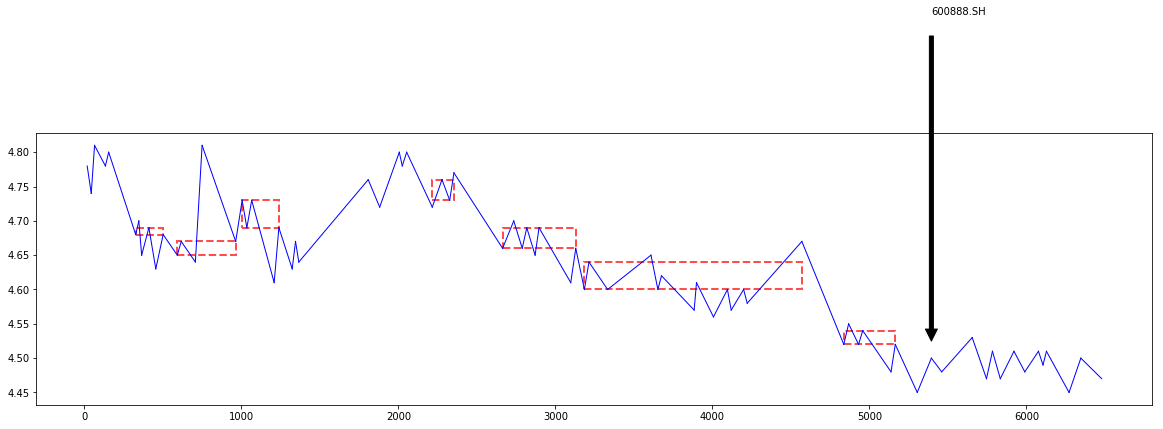

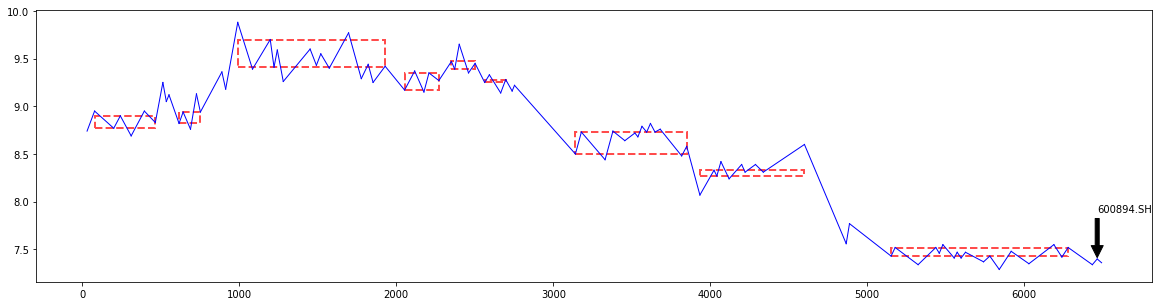

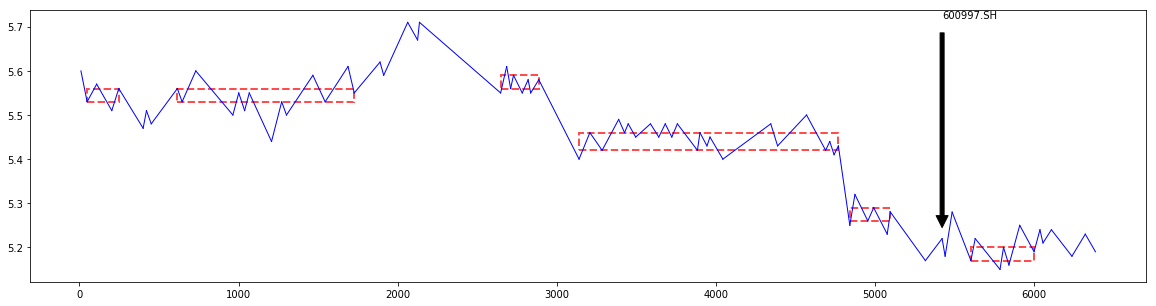

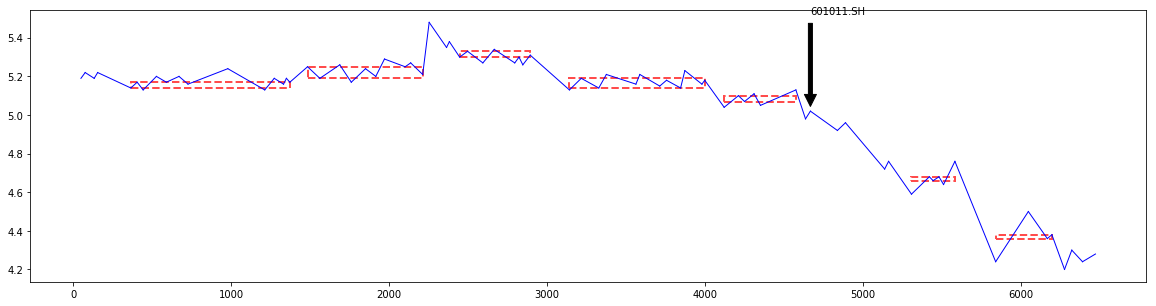

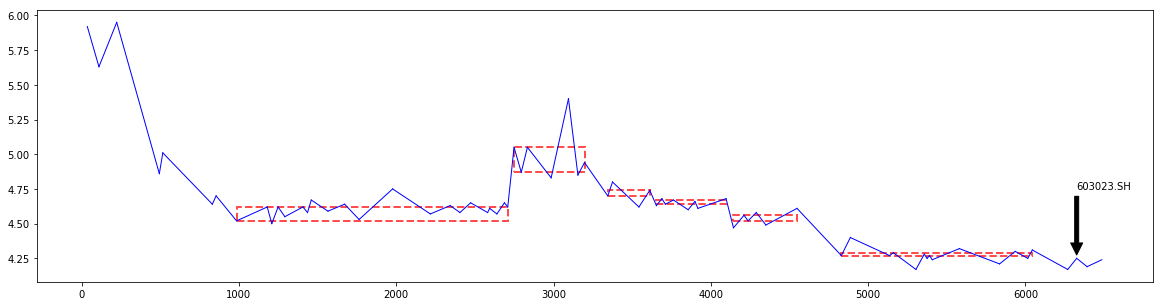

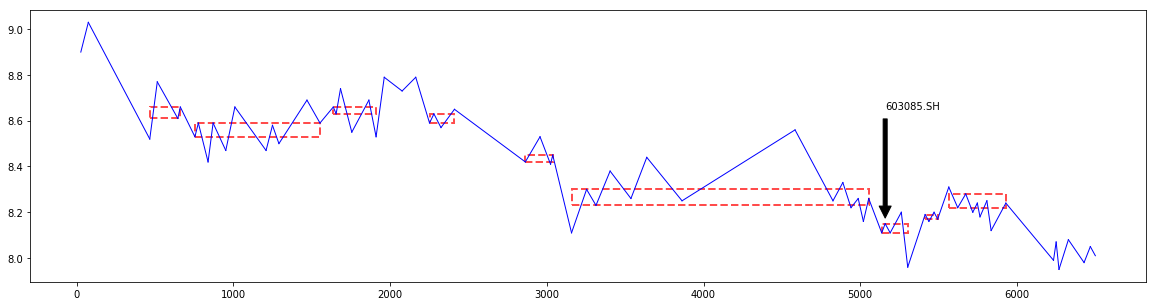

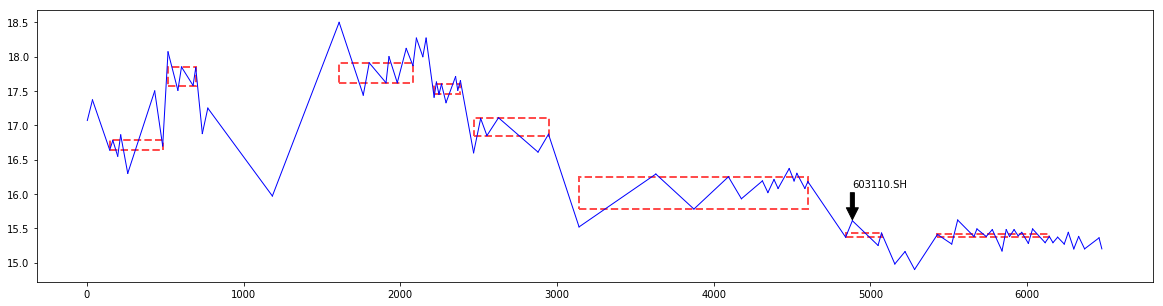

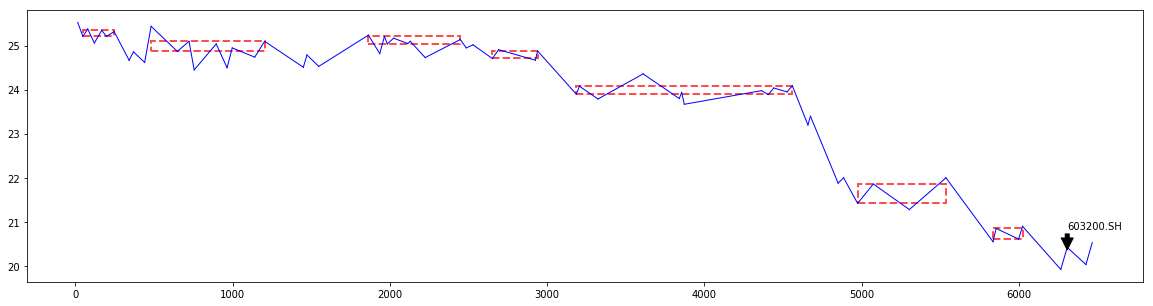

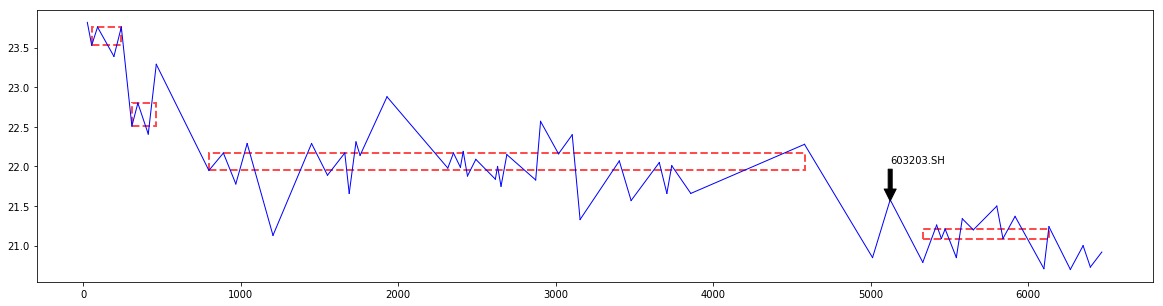

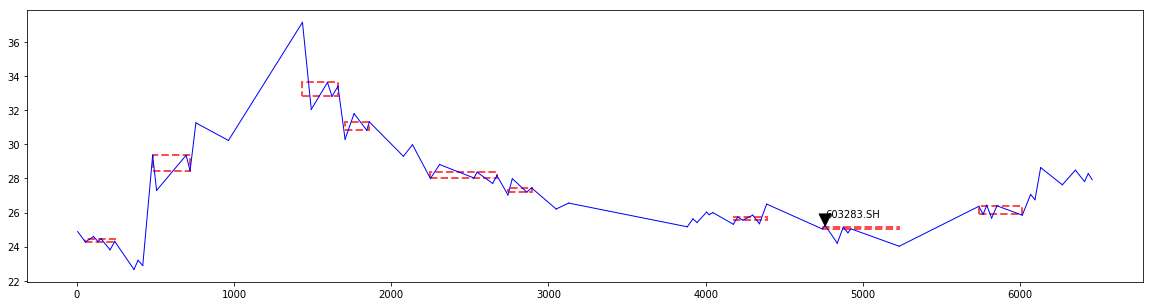

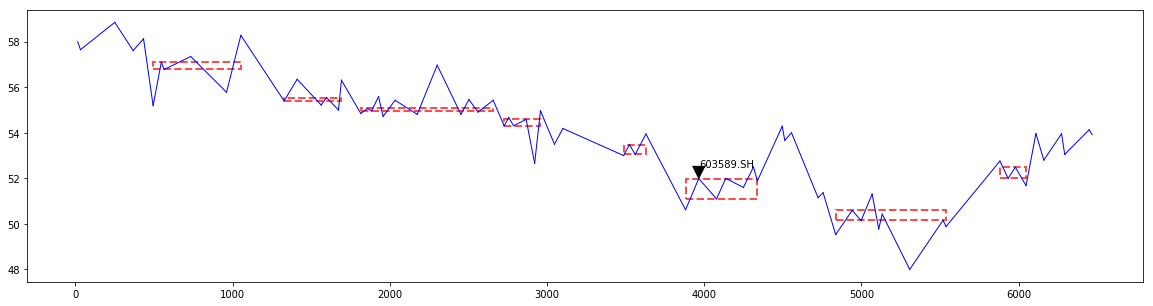

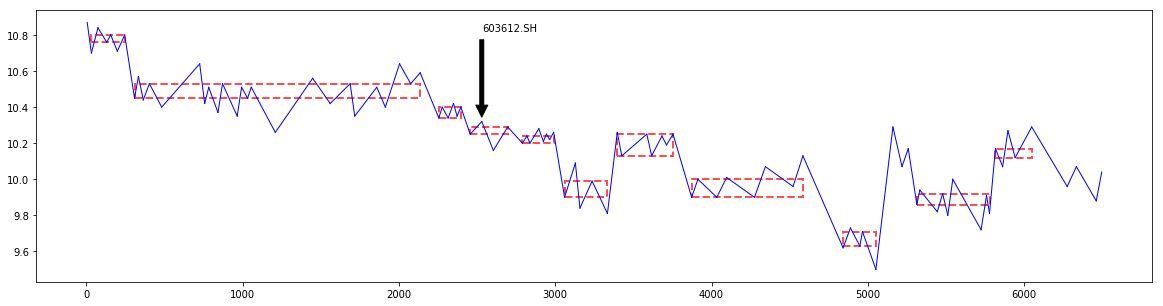

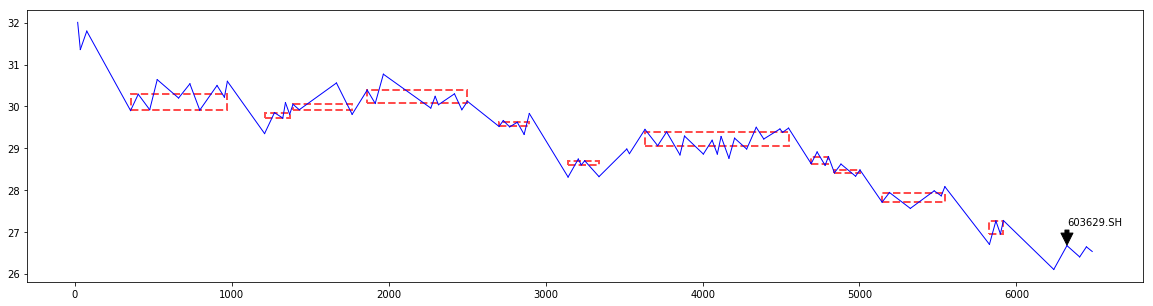

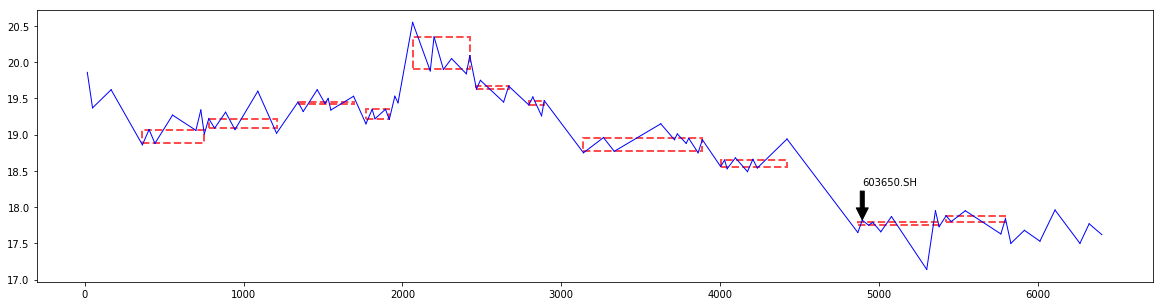

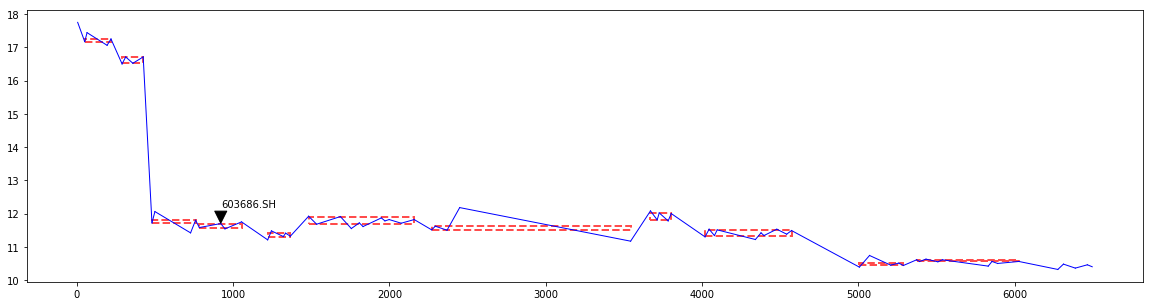

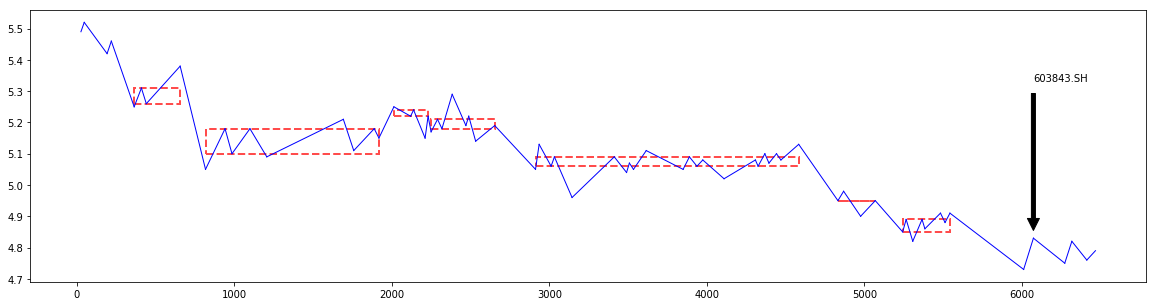

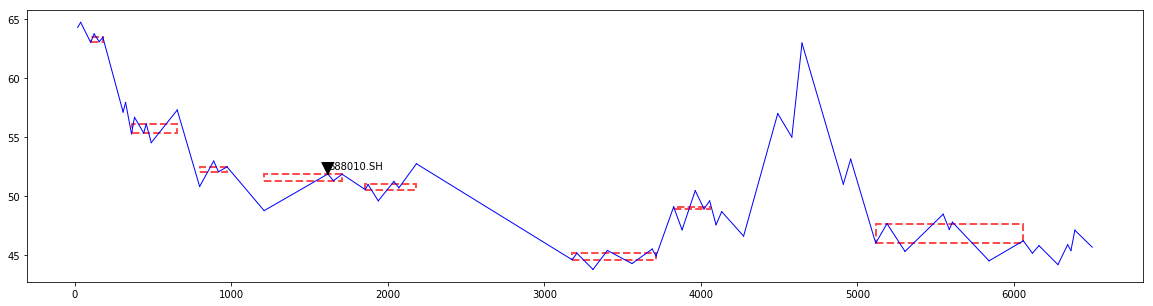

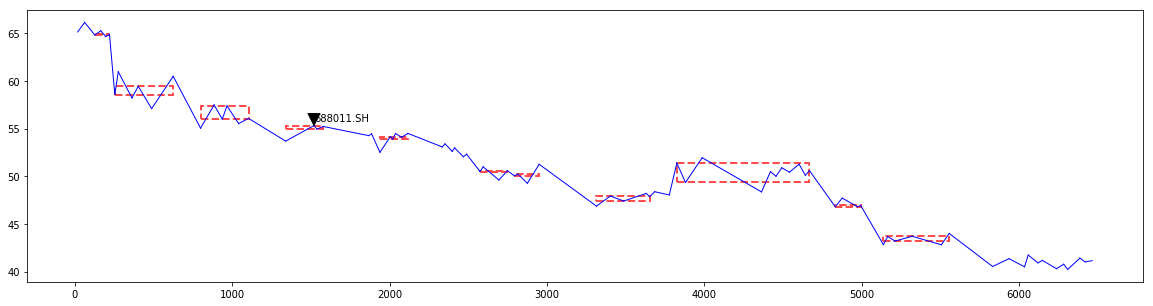

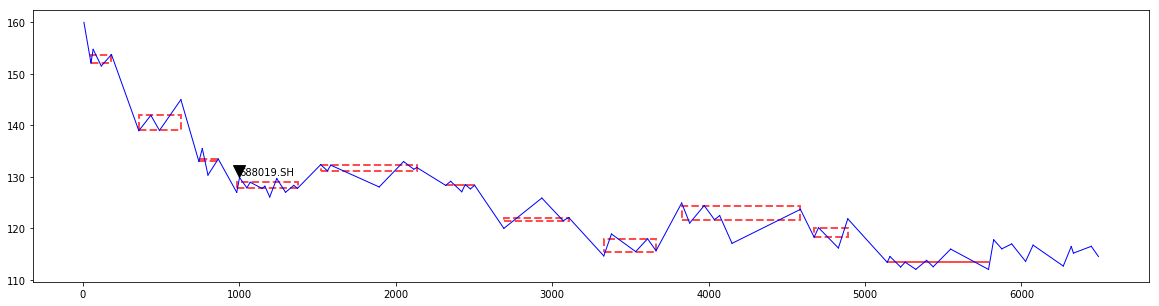

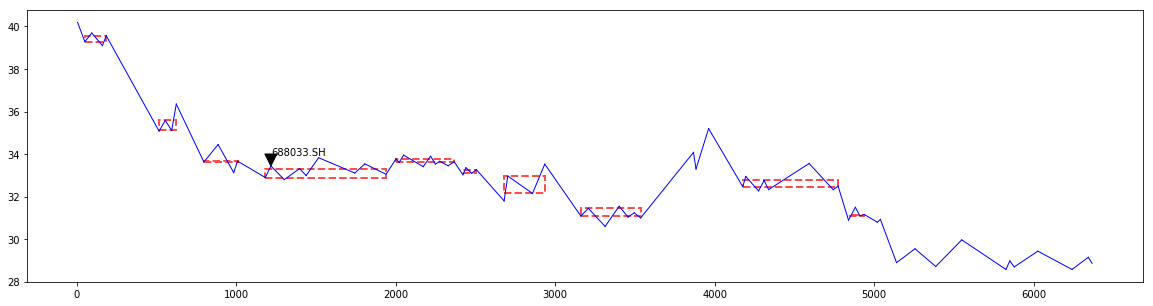

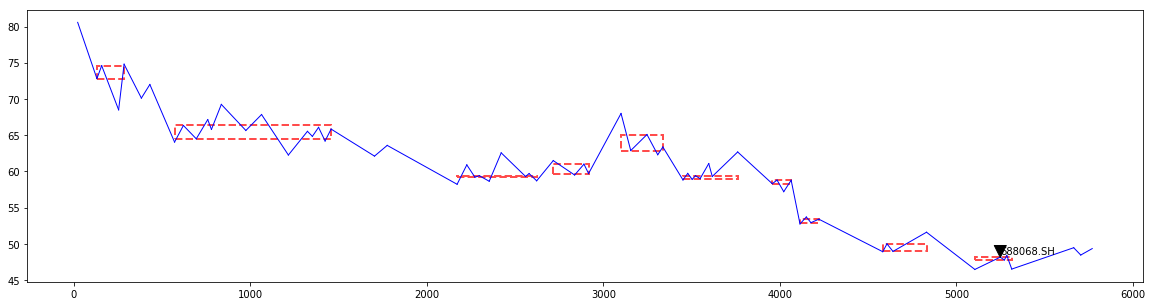

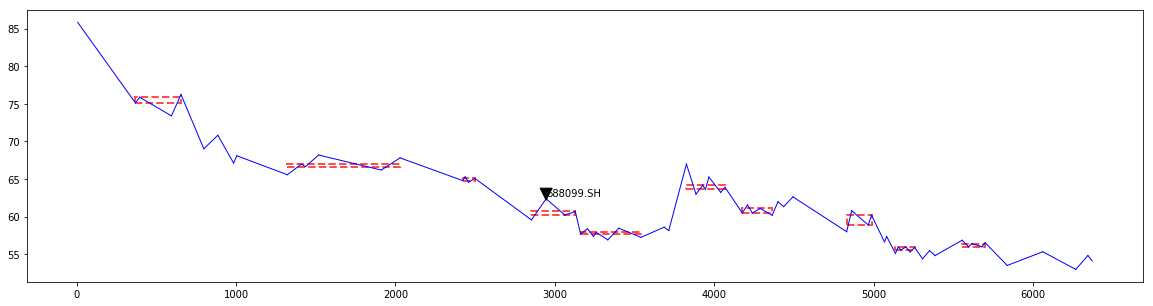

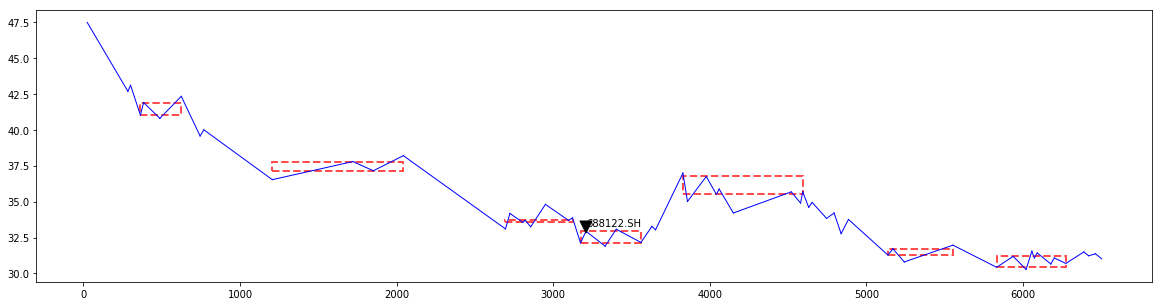

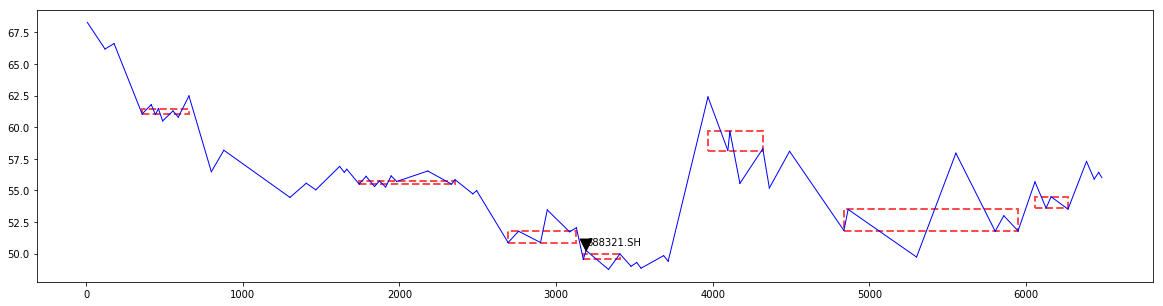

In [54]:
db = MySQLdb.connect(host="127.0.0.1",user="sa",passwd="sasasa",db="quant",charset="utf8")

df = pd.read_csv('E:\jupyter\qushi-20190925-20191108.csv',index_col='index')
df_down = df[df.direction=='downdown']
for stock_n, stock_k in df_down.iterrows():
    ts_code=stock_k.ts_code
    trade_time=stock_k.trade_time
    trade_price=stock_k.trade_price
    cursor = db.cursor()
    sql = "select * from stock_min where ts_code='"+ts_code+"' and trade_time>'2019-09-25' and trade_time<'2019-11-09' order by trade_time"
    df_dr = pd.read_sql(sql,db)
    cursor.close()
    reload(chan) #重新加载外部chan.py
    df_dr=chan.build(df_dr)
    
    plt.figure(figsize=(20,5),dpi=72)
    #画线段
    draw_dot_n_pre=None
    draw_dot_y_pre=None
    for n, k in df_dr[df_dr.line!=''].iterrows():
        line_type = k.line
        low = k.low
        high = k.high 
        if line_type=="top" or line_type=='bottom':
            y=low if line_type=='bottom' else high
            if draw_dot_n_pre!=None:
                plt.plot([draw_dot_n_pre,n],[draw_dot_y_pre,y],'b-',lw=1)
            draw_dot_n_pre=n
            draw_dot_y_pre=y
    #画中枢
    draw_zs_no_pre=0
    draw_zg_pre=0
    draw_zd_pre=0
    draw_zs_start_n_pre=0
    draw_zs_n_pre=0
    for n, k in df_dr[df_dr.zs_no>0].iterrows():
        zg = k.zg
        zd = k.zd
        zs_no = k.zs_no
        if draw_zs_no_pre!=zs_no: #开始了新的中枢，画上一个
            if draw_zs_no_pre!=0: 
                #print(draw_zs_start_n_pre,draw_zg_pre,draw_zd_pre,draw_zs_n_pre-draw_zs_start_n_pre,draw_zd_pre)
                plt.bar((draw_zs_start_n_pre+draw_zs_n_pre)/2,draw_zg_pre-draw_zd_pre,draw_zs_n_pre-draw_zs_start_n_pre,draw_zd_pre, color='w',alpha=0.7, edgecolor='r', ls='--',lw=2)
            draw_zs_start_n_pre=n
            draw_zs_no_pre=zs_no
            draw_zg_pre=zg
            draw_zd_pre=zd
        draw_zs_n_pre=n
    if draw_zs_no_pre!=0: #画最后一个
        #print(draw_zs_start_n_pre,draw_zg_pre,draw_zd_pre,draw_zs_n_pre-draw_zs_start_n_pre,draw_zd_pre)
        plt.bar((draw_zs_start_n_pre+draw_zs_n_pre)/2,draw_zg_pre-draw_zd_pre,draw_zs_n_pre-draw_zs_start_n_pre,draw_zd_pre, color='w',alpha=0.7, edgecolor='r', ls='--',lw=2)

    #画交易点
    trade_n=df_dr[df_dr.trade_time==trade_time].index[0]
    #print(trade_n,trade_price)
    plt.annotate(ts_code, xy=(trade_n, trade_price), xytext=(trade_n, trade_price+0.5),arrowprops=dict(facecolor='black', shrink=0.05),)
    #break
    
    plt.savefig('E:/jupyter/pic10/'+ts_code+'.png')
    plt.show()
db.close() 

In [21]:
df_dr[df_dr.trade_time=='2019-06-06 13:44:00']

ts_code          trade_time  open  close  high   low     vol   amount  \
2091  000650.SZ 2019-06-06 13:44:00  7.48   7.45  7.48  7.45  499400  3731289   

      trade_date  pre_close        ...          bi line  zs_no    zg    zd  \
2091  2019-06-06       7.46        ...         top  top      4  7.42  7.33   

        gg   dd zs_direction      zs_confirm_time  zs_confirm_price  
2091  7.48  7.2       downup  2019-06-11 13:29:00              7.71  

[1 rows x 27 columns]